In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
from dateutil.parser import parse
from datetime import datetime, timedelta
from collections import deque

%matplotlib inline

print("Pandas version:      ", pd.__version__)
print("NumPy version:       ", np.__version__)
print("SciKit Learn version:", sklearn.__version__)
print("TensorFlow version:  ", tf.__version__)
print("MatPlotLib version:  ", matplotlib.__version__)

seed = 8
tf.set_random_seed(seed)
np.random.seed(seed)

Pandas version:       0.22.0
NumPy version:        1.14.2
SciKit Learn version: 0.19.1
TensorFlow version:   1.6.0
MatPlotLib version:   2.2.0


In [2]:
dataframe = pd.read_csv('prices.csv')
dataframe.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,70.836986,70.857109,70.118414,71.543476,5.415113e+06
std,83.695876,83.689686,82.877294,84.465504,1.249468e+07
min,0.850000,0.860000,0.830000,0.880000,0.000000e+00
25%,33.840000,33.849998,33.480000,34.189999,1.221500e+06
50%,52.770000,52.799999,52.230000,53.310001,2.476250e+06
75%,79.879997,79.889999,79.110001,80.610001,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [3]:
dataframe.tail(10)

,date,symbol,open,close,low,high,volume
851254,2016-12-30,XRAY,58.290001,57.730000,57.540001,58.360001,949200.0
851255,2016-12-30,XRX,8.720000,8.730000,8.700000,8.800000,11250400.0
851256,2016-12-30,XYL,49.980000,49.520000,49.360001,50.000000,646200.0
851257,2016-12-30,YHOO,38.720001,38.669998,38.430000,39.000000,6431600.0
851258,2016-12-30,YUM,63.930000,63.330002,63.160000,63.939999,1887100.0
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
851263,2016-12-30 00:00:00,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [4]:
desired_columns = ['open', 'close']
basic_mlp_data = dataframe[desired_columns]
basic_mlp_data.head()

,open,close
0,123.430000,125.839996
1,125.239998,119.980003
2,116.379997,114.949997
3,115.480003,116.620003
4,117.010002,114.970001


In [8]:
# Call this in IPython notebooks before any elements are added to
# the default graph otherwise if you rerun cells you can get 
# annoying errors.
tf.reset_default_graph()

# Define the Neural Network topology with the 'net_hidden_sizes'
# and how much we should regularise it and how quickly it should
# learn. Also the type of non linearity we should use.
amount_epochs = 50
learning_rate = 0.001
batch_size = 128
net_hidden_sizes = [128, 64, 8]
l2_strength = 0.01
non_linearity = tf.nn.relu
dropout_amount = 0.7

# The input to the graph - the targets (close) and the inputs
# (open). Also a placeholder to pass a variable dropout rate. 
net_input = tf.placeholder(tf.float32, shape=[None, 1])
net_target = tf.placeholder(tf.float32, shape=[None, 1])
dropout_prob = tf.placeholder(tf.float32)

# L2 regularisation to penalise the weights from growing too
# large. Useful to prevent overfitting.
regulariser = tf.contrib.layers.l2_regularizer(scale=l2_strength)

# Build the network from the list of dimensions. Apply l2 and
# dropout regularisation to the layers.
net = net_input
for size in net_hidden_sizes:
    net = tf.layers.dense(inputs=net, 
                          units=size, 
                          activation=non_linearity, 
                          kernel_regularizer=regulariser)
    net = tf.layers.dropout(inputs=net,
                            rate=dropout_prob)

# The models prediction has a linear output. 
net_output = tf.layers.dense(inputs=net,
                             units=1, 
                             activation=None, 
                             kernel_regularizer=regulariser)    

# The main loss for penalising the network on how well it does.
loss = tf.losses.mean_squared_error(labels=net_target, 
                                    predictions=net_output)

# TensorFlows manner of applying l2 to the loss.
l2_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
l2_loss = tf.contrib.layers.apply_regularization(regulariser, 
                                                 l2_variables)
total_loss = loss + l2_loss

# Train and initialisation TensorFlow operations to be ran
# in the session.
train_op = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
init_op = tf.global_variables_initializer()
print('ffff')

ffff


In [9]:
with tf.Session() as sess:
    
    amount_folds = 5
    k_folds = KFold(n_splits=amount_folds)
    data = basic_mlp_data.as_matrix()
    fold_errors = []
    fold_iteration = 0
    
    # Cross validate the dataset, using K-Fold.
    for train_indices, test_indices in k_folds.split(data):

        # Each new fold, reinitialise the network.
        sess.run(init_op)
        
        # Training phase.
        for epoch in range(amount_epochs):
            
            # Each new epoch, reshuffle the train set.
            random_train_indices = np.random.permutation(train_indices)
            train_set = data[random_train_indices]
            
            # Loop over the train set and optimise the network.
            for begin in range(0, len(train_set), batch_size):
                end = begin + batch_size
                batch_x = train_set[begin:end].T[0].reshape((-1, 1))
                batch_y = train_set[begin:end].T[1].reshape((-1, 1))
                
                sess.run(train_op, feed_dict={
                    net_input: batch_x,
                    net_target: batch_y,
                    dropout_prob: dropout_amount
                })
        
        # Testing phase.
        test_set = data[test_indices]
        
        # Collate the error over the test set.
        all_error = []
        for begin in range(0, len(test_set), batch_size):
            end = begin + batch_size 
            batch_x = train_set[begin:end].T[0].reshape((-1, 1))
            batch_y = train_set[begin:end].T[1].reshape((-1, 1))
            
            error = sess.run(loss, feed_dict={
                net_input: batch_x,
                net_target: batch_y,
                dropout_prob: 1.0
            }) 
            all_error.append(error)
        
        all_error = np.array(all_error).reshape((-1))
        fold_errors.append(all_error)
        
        print("\nFold iteration:  ", fold_iteration,
              "\nError mean:      ", np.mean(all_error),
              "\nError deviation: ", np.std(all_error),
              "\n")
        fold_iteration += 1      
        
    fold_errors = np.array(fold_errors).reshape((amount_folds, -1))
    print('fff')


Fold iteration:   0 
Error mean:       2.7146893 
Error deviation:  3.3762183 


Fold iteration:   1 
Error mean:       3.507859 
Error deviation:  3.1102047 


Fold iteration:   2 
Error mean:       2.104382 
Error deviation:  2.184533 


Fold iteration:   3 
Error mean:       2.0846407 
Error deviation:  1.8512129 


Fold iteration:   4 
Error mean:       1.8507316 
Error deviation:  1.9735212 

fff


In [10]:
print('dgdfgd')

dgdfgd


<Figure size 432x288 with 0 Axes>

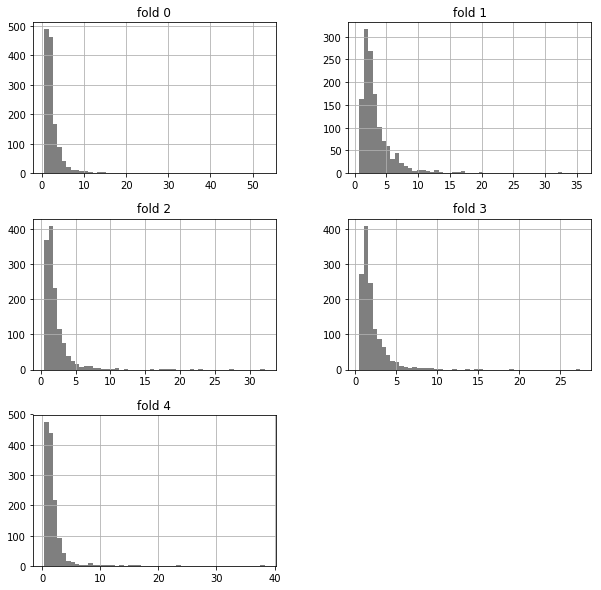

In [11]:
hist_data = dict()
keys = ['fold 0', 'fold 1', 'fold 2', 'fold 3', 'fold 4']
for i, key in enumerate(keys):
    hist_data[key] = fold_errors[i]
    

plt.figure()
hist_dataframe = pd.DataFrame(hist_data, columns=keys)
_ = hist_dataframe.hist(color='k', alpha=0.5, bins=50, figsize=(10, 10))

In [12]:
sequence_desired_cols = ['date', 'symbol', 'close']
sequence_data = dataframe[sequence_desired_cols]
sequence_data = sequence_data.sort_values(by=['symbol', 'date'])
sequence_data.head()

,date,symbol,close
251,2010-01-04,A,31.300001
718,2010-01-05,A,30.960001
1186,2010-01-06,A,30.850001
1654,2010-01-07,A,30.809999
2122,2010-01-08,A,30.800000


In [13]:
sequence_length = 3

all_data = deque()

previous_date = None
previous_class = None
reset = False
close_deque = deque()

for index, row in sequence_data.iterrows():
    current_date = parse(row['date'])
    current_class = row['symbol']
    
    first_value = previous_date == None and previous_class == None
    if not first_value:
        successive_date = current_date == (previous_date + timedelta(days=1))
    successive_class = current_class == previous_class
    append = first_value or (successive_date and successive_class)

    if append:
        close_deque.append(row['close'])
        
        if len(close_deque) > sequence_length:
            target_close = close_deque.pop()
            all_data.append((list(close_deque), [target_close]))
            reset = True
            
    if not append or reset:
        close_deque.clear()
        previous_date = None
        previous_class = None
        reset = False
        
    previous_date = current_date
    previous_class = current_class

In [14]:
x_data, y_data = list(zip(*all_data))
x_data = np.array(x_data).reshape((-1, sequence_length, 1))
y_data = np.array(y_data)
print("x shape:", x_data.shape, 
      "\ny shape:", y_data.shape)

all_distances = []
for i in range(len(x_data)):
    all_distances.append(np.abs(np.mean(x_data[i]) - y_data[i][0]))
all_distances = np.array(all_distances)

print("sequence difference mean:", np.mean(all_distances), 
      "\nsequence difference max: ", np.max(all_distances), 
      "\nsequence difference min: ", np.min(all_distances), 
      "\nsequence difference std: ", np.std(all_distances))

x shape: (146379, 3, 1) 
y shape: (146379, 1)
sequence difference mean: 1.0803335451465035 
sequence difference max:  401.91332466666665 
sequence difference min:  0.0 
sequence difference std:  2.889675018801449


In [15]:
close_deque.head()

AttributeError: 'collections.deque' object has no attribute 'head'

In [16]:
print(close_deque)

deque([53.439999, 53.619999, 53.529999])


In [17]:
print(close_deque)

deque([53.439999, 53.619999, 53.529999])


In [18]:
print( target_close)

53.779999


In [19]:
# Again reset the graph
tf.reset_default_graph()

# Network parameters
rnn_layer_sizes = [64, 32, 16]
net_hidden_sizes = [8, 4]
amount_epochs = 50
learning_rate = 0.001
batch_size = 32
l2_strength = 0.001
non_linearity = tf.nn.relu
dropout_amount = 0.4
max_grad_norm = 5.0
decay = True
cell_type = "rnn"

# The input to the graph - the targets (close) and the inputs
# (open). Also a placeholder to pass a variable dropout rate. 
net_input = tf.placeholder(tf.float32, shape=[None, sequence_length, 1])
net_target = tf.placeholder(tf.float32, shape=[None, 1])
dropout_prob = tf.placeholder(tf.float32)

# Create a stacked GRU with dropout using the rnn_layer_sizes
# list to for the lstm memory size.
cells = []
for num_units in rnn_layer_sizes:
    if cell_type == "rnn":
        cell = tf.contrib.rnn.BasicRNNCell(num_units)
    elif cell_type == "gru":
        cell = tf.contrib.rnn.GRUCell(num_units)
    elif cell_type == "lstm":
        cell = tf.contrib.rnn.LSTMCell(num_units)
    cell = tf.contrib.rnn.DropoutWrapper(cell=cell, 
                                         output_keep_prob=dropout_prob)
    cells.append(cell)
rnn_cell = tf.contrib.rnn.MultiRNNCell(cells)
rnn_out, _ = tf.nn.dynamic_rnn(cell=rnn_cell,
                               inputs=net_input,
                               sequence_length=None,
                               dtype=tf.float32)
rnn_output = rnn_out[:, -1, :]
                        
# L2 regularisation to penalise the weights from growing too
# large. Useful to prevent overfitting.
regulariser = tf.contrib.layers.l2_regularizer(scale=l2_strength)

# Build the network from the list of dimensions. Apply l2 and
# dropout regularisation to the layers.
net = rnn_output
for size in net_hidden_sizes:
    net = tf.layers.dense(inputs=net, 
                          units=size, 
                          activation=non_linearity, 
                          kernel_regularizer=regulariser)
    net = tf.layers.dropout(inputs=net,
                            rate=dropout_prob)
    
# The models prediction has a linear output. 
net_output = tf.layers.dense(inputs=net,
                             units=1, 
                             activation=None, 
                             kernel_regularizer=regulariser)   

# The main loss for penalising the network on how well it does.
loss = tf.losses.mean_squared_error(labels=net_target, 
                                    predictions=net_output)

# TensorFlows manner of applying l2 to the loss.
l2_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
l2_loss = tf.contrib.layers.apply_regularization(regulariser, 
                                                 l2_variables)
cost = loss + l2_loss

# Train and initialisation TensorFlow operations to be ran
# in the session.
trainables = tf.trainable_variables()
gradients = tf.gradients(cost, trainables)

# Clip the gradients by a pre-defined max norm.
clipped_gradients, _ = tf.clip_by_global_norm(gradients, max_grad_norm)

# Add the clipped gradients to the optimizer.
batch = tf.Variable(0)
if decay:
    decayed_learning_rate = tf.train.exponential_decay(learning_rate,
                                                       batch * batch_size,
                                                       117103,
                                                       0.999,
                                                       staircase=True)
else:
    decayed_learning_rate = learning_rate
optimiser = tf.train.AdamOptimizer(decayed_learning_rate)
train_op = optimiser.apply_gradients(zip(gradients, trainables), global_step=batch)

init_op = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    
    amount_folds = 5
    k_folds = KFold(n_splits=amount_folds)
    fold_errors = []
    fold_iteration = 0
    
    # Cross validate the dataset, using K-Fold.
    for train_indices, test_indices in k_folds.split(x_data):

        # Each new fold, reinitialise the network.
        sess.run(init_op)
        
        # Training phase.
        for epoch in range(amount_epochs):
            
            # Each new epoch, reshuffle the train set.
            random_train_indices = np.random.permutation(train_indices)
                
            # Loop over the train set and optimise the network.
            for begin in range(0, len(train_indices), batch_size):
                end = begin + batch_size
                batch_x = x_data[random_train_indices][begin:end]
                batch_y = y_data[random_train_indices][begin:end]
                
                sess.run(train_op, feed_dict={
                    net_input: batch_x,
                    net_target: batch_y,
                    dropout_prob: dropout_amount
                })
                
            # Testing phase - record the error over the test set.
            epoch_error = []
            for begin in range(0, len(test_indices), batch_size):
                end = begin + batch_size 
                batch_x = x_data[test_indices][begin:end]
                batch_y = y_data[test_indices][begin:end]

                error = sess.run(loss, feed_dict={
                    net_input: batch_x,
                    net_target: batch_y,
                    dropout_prob: 1.0
                }) 
                epoch_error.append(error)
        
            epoch_error = np.array(epoch_error).reshape((-1))    
                
            print('\nepoch:', epoch,
                  '\nmean: ', np.mean(epoch_error), 
                  '\nstd:  ', np.std(epoch_error),
                  '\nmax:  ', np.max(epoch_error),
                  '\nmin:  ', np.min(epoch_error))
 
                
        # Testing phase - record the error over the test set.
        all_error = []
        for begin in range(0, len(test_indices), batch_size):
            end = begin + batch_size 
            batch_x = x_data[test_indices][begin:end]
            batch_y = y_data[test_indices][begin:end]
            
            error = sess.run(loss, feed_dict={
                net_input: batch_x,
                net_target: batch_y,
                dropout_prob: 1.0
            }) 
            all_error.append(error)
        
        all_error = np.array(all_error).reshape((-1))
        fold_errors.append(all_error)
        
        print("\nFold iteration:  ", fold_iteration,
              "\nError mean:      ", np.mean(all_error),
              "\nError deviation: ", np.std(all_error),
              "\n")
        fold_iteration += 1      
        
    fold_errors = np.array(fold_errors).reshape((amount_folds, -1))


epoch: 0 
mean:  721.33075 
std:   2308.574 
max:   35362.074 
min:   1.7973319

epoch: 1 
mean:  2137.9998 
std:   10196.638 
max:   91839.15 
min:   1.3896139

epoch: 2 
mean:  1135.5055 
std:   3917.1047 
max:   36914.82 
min:   0.40987504

epoch: 3 
mean:  818.9724 
std:   2705.2488 
max:   20617.607 
min:   1.3089634

epoch: 4 
mean:  771.45435 
std:   2310.222 
max:   16013.056 
min:   1.2987884

epoch: 5 
mean:  1151.4763 
std:   4266.7446 
max:   41843.258 
min:   1.401023

epoch: 6 
mean:  1033.2899 
std:   3759.023 
max:   41061.234 
min:   0.89134514

epoch: 7 
mean:  1272.3566 
std:   5045.561 
max:   45063.926 
min:   1.0281136

epoch: 8 
mean:  968.43945 
std:   3626.5784 
max:   30605.602 
min:   1.3993125

epoch: 9 
mean:  1538.4425 
std:   6435.4844 
max:   82717.97 
min:   1.4028656

epoch: 10 
mean:  940.7086 
std:   3303.3738 
max:   28783.959 
min:   1.0855678

epoch: 11 
mean:  962.43976 
std:   3597.654 
max:   36250.53 
min:   1.0256746

epoch: 12 
mean:  709.0